In [86]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [87]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [88]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


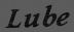

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


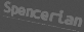

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


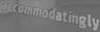

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


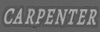

In [89]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [90]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


In [91]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
print("슝~")

슝~


In [92]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [93]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [94]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


In [95]:
from tensorflow.keras import backend as K

# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01, clipnorm=5)

# 모델 컴파일
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)



In [96]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# 한 에포크 당 배치의 총 개수를 계산
batches_per_epoch = len(train_set)

# ModelCheckpoint 콜백 설정
# 5번째, 10번째, 마지막 epoch에서 모델 저장
ckp_5 = ModelCheckpoint(
    checkpoint_path.format(epoch=5),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    save_freq=5 * batches_per_epoch  # 5번째 에포크마다 저장
)

ckp_10 = ModelCheckpoint(
    checkpoint_path.format(epoch=10),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    save_freq=10 * batches_per_epoch  # 10번째 에포크마다 저장
)

ckp_last = ModelCheckpoint(
    checkpoint_path.format(epoch=total_epochs),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    save_freq=total_epochs * batches_per_epoch  # 마지막 에포크에서 저장
)

# EarlyStopping 콜백 설정
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

# 모델 학습
history = model.fit(
    train_set,
    steps_per_epoch=batches_per_epoch,
    epochs=total_epochs,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[ckp_5, ckp_10, ckp_last, earlystop]
)

Epoch 1/20
565/565 [==============================] - 89s 148ms/step - loss: 27.3879 - val_loss: 26.2878
Epoch 2/20
565/565 [==============================] - 82s 144ms/step - loss: 25.4405 - val_loss: 25.8087
Epoch 3/20
565/565 [==============================] - 81s 144ms/step - loss: 24.8939 - val_loss: 24.8793
Epoch 4/20
565/565 [==============================] - 82s 145ms/step - loss: 24.4184 - val_loss: 24.5240
Epoch 5/20
565/565 [==============================] - ETA: 0s - loss: 23.9796
Epoch 00005: saving model to /aiffel/aiffel/ocr/model_checkpoint_5.hdf5
565/565 [==============================] - 82s 145ms/step - loss: 23.9796 - val_loss: 24.0389
Epoch 6/20
565/565 [==============================] - 82s 145ms/step - loss: 23.5688 - val_loss: 23.6196
Epoch 7/20
565/565 [==============================] - 82s 145ms/step - loss: 23.1454 - val_loss: 23.5599
Epoch 8/20
565/565 [==============================] - 82s 145ms/step - loss: 22.6675 - val_loss: 22.7690
Epoch 9/20
565/565 [=

미션 2 : 학습 단계별 평가

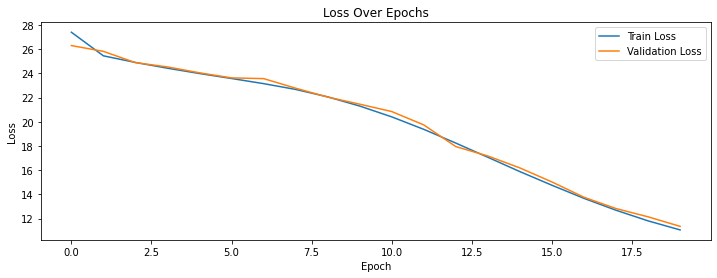

In [97]:
import matplotlib.pyplot as plt

# 학습 손실과 검증 손실 그리기
plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [100]:
def load_model_and_evaluate(model_path, test_set):
    # 모델 가중치 로드
    model.load_weights(model_path)

    # 모델 평가, 손실만 반환
    loss = model.evaluate(test_set, steps=len(test_set))
    return loss

# 각 체크포인트의 모델 로드 및 평가
epochs = [5, 10, total_epochs]  # 체크포인트 epoch 번호
checkpoint_paths = [HOME_DIR + f'/model_checkpoint_{epoch}.hdf5' for epoch in epochs]
results = {}

for epoch, model_path in zip(epochs, checkpoint_paths):
    loss = load_model_and_evaluate(model_path, test_set)
    results[epoch] = {'loss': loss}

# 결과 출력
for epoch in epochs:
    print(f"Epoch {epoch}: Loss = {results[epoch]['loss']}")



70/70 [==============================] - 6s 82ms/step - loss: 11.1981
Epoch 5: Loss = 11.19813346862793
Epoch 10: Loss = 11.19813346862793
Epoch 20: Loss = 11.19813346862793


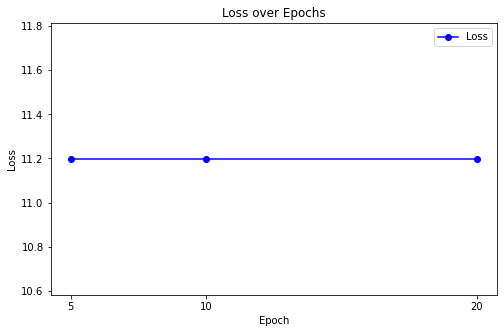

In [101]:
import matplotlib.pyplot as plt

# 체크포인트 별 손실 값
loss_values = [results[epoch]['loss'] for epoch in epochs]

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()


In [102]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


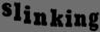

Result: 	 ALEPPO99999999999999999


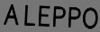

Result: 	 FWANDA999999999999999999


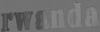

Result: 	 NATHANS99999999999999999


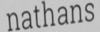

Result: 	 HALLE999999999999999999


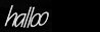

Result: 	 HURLS9999999999999999999


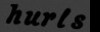

Result: 	 DOWNSIZE9999999999999999


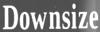

Result: 	 ROBOTIC99999999999999999


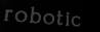

Result: 	 SLOPPY99999999999999999


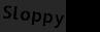

Result: 	 SHERMITE9999999999999999


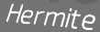

In [103]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

미션 3: pytesseract 와 google vision api 써보기

In [104]:
# 혹은 터미널에서 !를 제거 후 실행하도록 합니다
! sudo apt install tesseract-ocr
! sudo apt install libtesseract-dev
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfc

In [105]:
import pytesseract
from pytesseract import Output

In [106]:
#한 줄의 코드로 pytesseract의 OCR을 수행할 수 있습니다
from PIL import Image

img = Image.open(path)
result = pytesseract.image_to_string(img)

IsADirectoryError: [Errno 21] Is a directory: '/aiffel/aiffel/ocr'

In [ ]:
#한국어 사용을 위해서는 테서렉트의 언어팩을 설치해야 합니다
from PIL import Image

img = Image.open(path)
result = pytesseract.image_to_string(img)

Google Cloud Vision API에서 사용해보기

In [ ]:
from google.cloud import vision

In [ ]:
client = vision.ImageAnnotatorClient()
with io.open(path, 'rb') as image_file:
		content = image_file.read()    
    img = vision.Image(content=content)
    response = client.text_detection(image = img)